# Red Neuronal Recurrente LSTM 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
# import tensorflowjs as tfjs
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError 

### Este modelo de IA realizará el análisis técnico sobre la criptmoneda Bitcoin (BTC)

#### Importación de bibliotecas

In [2]:
def categorize(change):
    if change >= 0.00:
        return 1
    else:
        return 0

#### Dataset

In [3]:
bp = pd.read_csv("./BitcoinHistoricalData.csv",index_col='Date',parse_dates=['Date']).iloc[::-1]

In [4]:
columns = ["Price","Open","High","Low","Vol.","Change %"]

for col in columns:
    bp[col] = pd.to_numeric(bp[col].replace({',': '', 'K': 'e3', 'M': 'e6', 'B': 'e9','%':''}, regex=True), errors='coerce')

In [5]:
bp['Category'] = [categorize(i) for i in bp['Change %']]

Se verifica que los tipos de datos sean los correctos

In [6]:
bp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3597 entries, 2015-01-01 to 2024-11-05
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     3597 non-null   float64
 1   Open      3597 non-null   float64
 2   High      3597 non-null   float64
 3   Low       3597 non-null   float64
 4   Vol.      3597 non-null   float64
 5   Change %  3597 non-null   float64
 6   Category  3597 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 224.8 KB


In [7]:
bp.describe()

,Price,Open,High,Low,Vol.,Change %,Category
count,3597.000000,3597.000000,3597.000000,3597.000000,3.597000e+03,3597.000000,3597.000000
mean,18972.431693,18953.323603,19397.037503,18480.269753,1.716868e+07,0.218229,0.527940
std,20296.760769,20281.762563,20729.831463,19802.906487,1.823784e+08,3.681176,0.499288
min,164.900000,164.900000,212.600000,157.300000,2.600000e+02,-39.180000,0.000000
25%,2508.600000,2492.600000,2576.700000,2375.900000,5.668000e+04,-1.230000,0.000000
50%,9507.300000,9494.100000,9706.500000,9262.700000,1.051500e+05,0.130000,1.000000
75%,30310.300000,30305.900000,30782.200000,29739.900000,3.115400e+05,1.710000,1.000000
max,73066.300000,73066.700000,73740.900000,71460.000000,4.470000e+09,27.200000,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

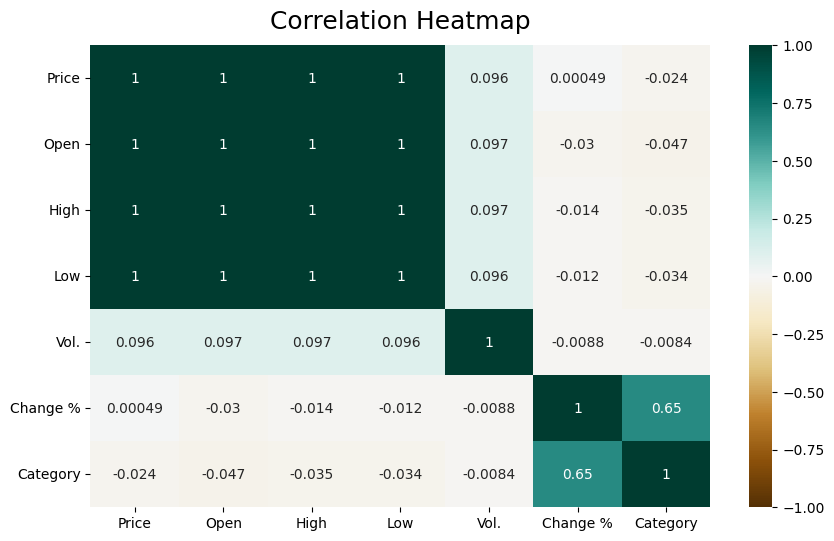

In [8]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(bp.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

Verificación de valores nulos

In [9]:
bp.isnull().sum()

Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
Category    0
dtype: int64

Dataset de Entrenamiento (2011 - 2019)

In [10]:
train_set = bp[:'2019'].iloc[:,[0]]
# train_set_target = to_categorical(bp[:'2019'].iloc[:,[6]], num_classes=3)

Dataset de Prueba (2022 - 2024)

In [11]:
test_set = bp['2020':].iloc[:,[0]]
# validation_set_target = to_categorical(bp['2022':'2023'].iloc[:,[6]], num_classes=3)

Visualizacion de Datasets

Text(0, 0.5, 'Precio')

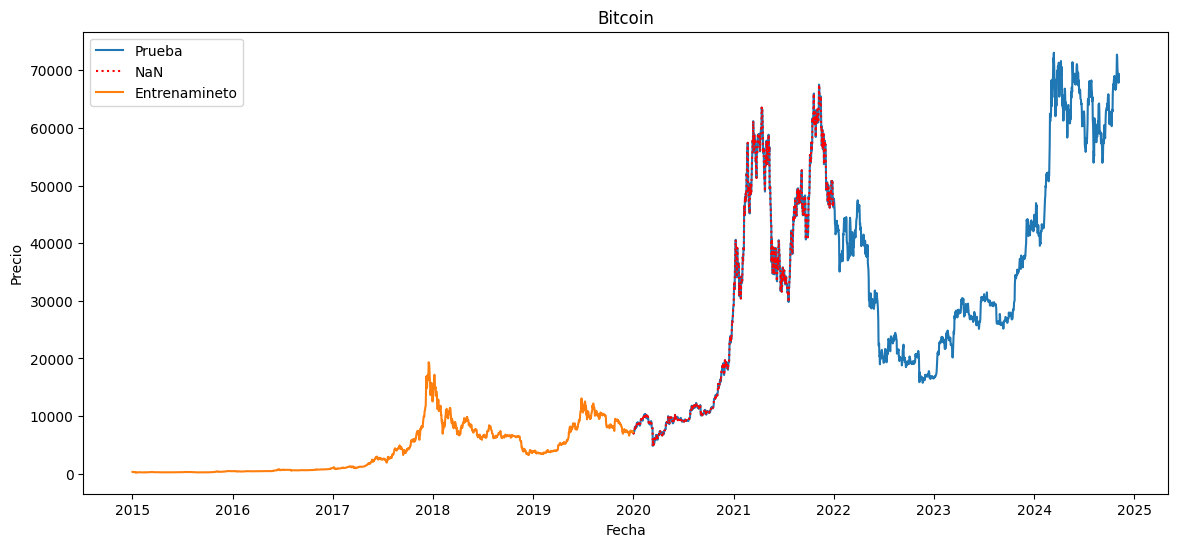

In [12]:
plt.figure(figsize=(14,6))
plt.title("Bitcoin")
sns.lineplot(x="Date", y="Price", data=test_set, label="Prueba")
sns.lineplot(x="Date", y="Price", data=bp['2020':'2021'].iloc[:,[0]], label="NaN",linestyle='dotted', color='red')
sns.lineplot(x="Date", y="Price", data=train_set, label="Entrenamineto")
plt.xlabel("Fecha")
plt.ylabel("Precio")

### Normalización de los datos

In [13]:
sc = MinMaxScaler(feature_range=(0,1))
train_set_scaled = sc.fit_transform(train_set)    

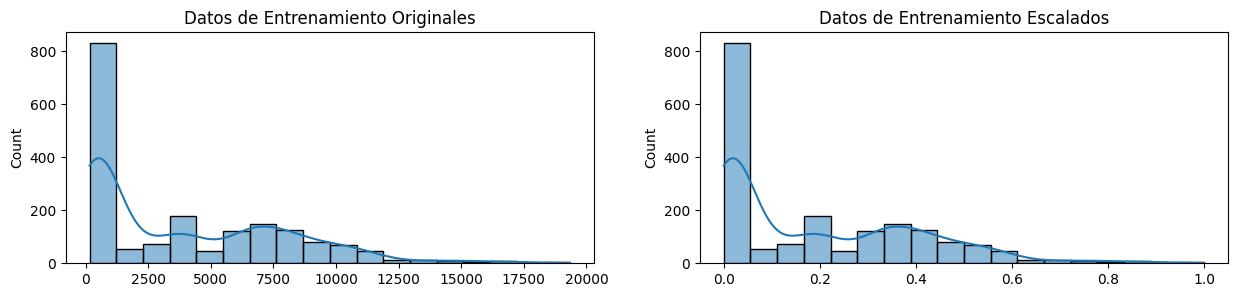

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(train_set, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Datos de Entrenamiento Originales")
sns.histplot(train_set_scaled, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Datos de Entrenamiento Escalados")
plt.show()

### Ajuste de los sets de entrenamineto y validación

In [15]:
block_size = 60
X_train = []
Y_train = []    
m = len(train_set_scaled)

for i in range(block_size,m):
    # Para X_train toma los primeros 'block_size' valores del dataset y Y_train toma el siguiente valor 
    X_train.append(train_set_scaled[i-block_size:i,0])
    Y_train.append(train_set_scaled[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train) 

In [16]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_train.shape

### Creación y entrenamiento de la Red LSTM

In [17]:
input_dim = (X_train.shape[1],X_train.shape[2])
output_dim = 1
na = 60

In [18]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Model Construction
model = Sequential()

# First Bidirectional LSTM Layer with Dropout and BatchNormalization
model.add(Bidirectional(LSTM(units=na, return_sequences=True), input_shape=input_dim))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Second Bidirectional LSTM Layer with fewer units
model.add(Bidirectional(LSTM(units=na // 2, return_sequences=True)))
# model.add(Dropout(0.3))
model.add(BatchNormalization())

# Third LSTM layer without bidirectionality, focusing on sequential data
model.add(LSTM(units=na // 4, return_sequences=False))
# model.add(Dropout(0.3))

# Dense layers to refine the output
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(units=output_dim, activation='linear'))  # Output layer for continuous prediction

# Compiling the model with advanced metrics
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[
        MeanSquaredError(),
        MeanAbsoluteError(),
        MeanAbsolutePercentageError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

# Model Training
hist = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

# Model Summary
model.summary()

#  # Construcción del modelo
# model = Sequential()
# model.add(Input(shape=input_dim))
# model.add(LSTM(units=na, return_sequences=True))
# model.add(LSTM(units=na, return_sequences=False))
# model.add(Dense(25))
# model.add(Dense(units=output_dim))

# # Compilación del modelo con métricas adicionales
# model.compile(
#     optimizer='adam',
#     loss='mean_squared_error',
#     metrics=[MeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()]
# )

# # Entrenamiento del modelo
# hist = model.fit(
#     X_train, Y_train,
#     epochs=20,
#     batch_size=64,
#     validation_split=0.2  # Opción para ver las métricas también en validación
# )

# # Resumen del modelo
# model.summary()

Epoch 1/50
45/45 [==============================] - 28s 300ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0438 - mean_absolute_percentage_error: 122.0709 - root_mean_squared_error: 0.0762 - val_loss: 0.1068 - val_mean_squared_error: 0.1068 - val_mean_absolute_error: 0.3046 - val_mean_absolute_percentage_error: 78.6485 - val_root_mean_squared_error: 0.3268 - lr: 0.0010
Epoch 2/50
45/45 [==============================] - 10s 217ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0273 - mean_absolute_percentage_error: 66.8418 - root_mean_squared_error: 0.0440 - val_loss: 0.0806 - val_mean_squared_error: 0.0806 - val_mean_absolute_error: 0.2603 - val_mean_absolute_percentage_error: 65.6268 - val_root_mean_squared_error: 0.2839 - lr: 0.0010
Epoch 3/50
45/45 [==============================] - 6s 125ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0235 - mean_absolute_percentage_error: 54.4297 - root_mean_squar

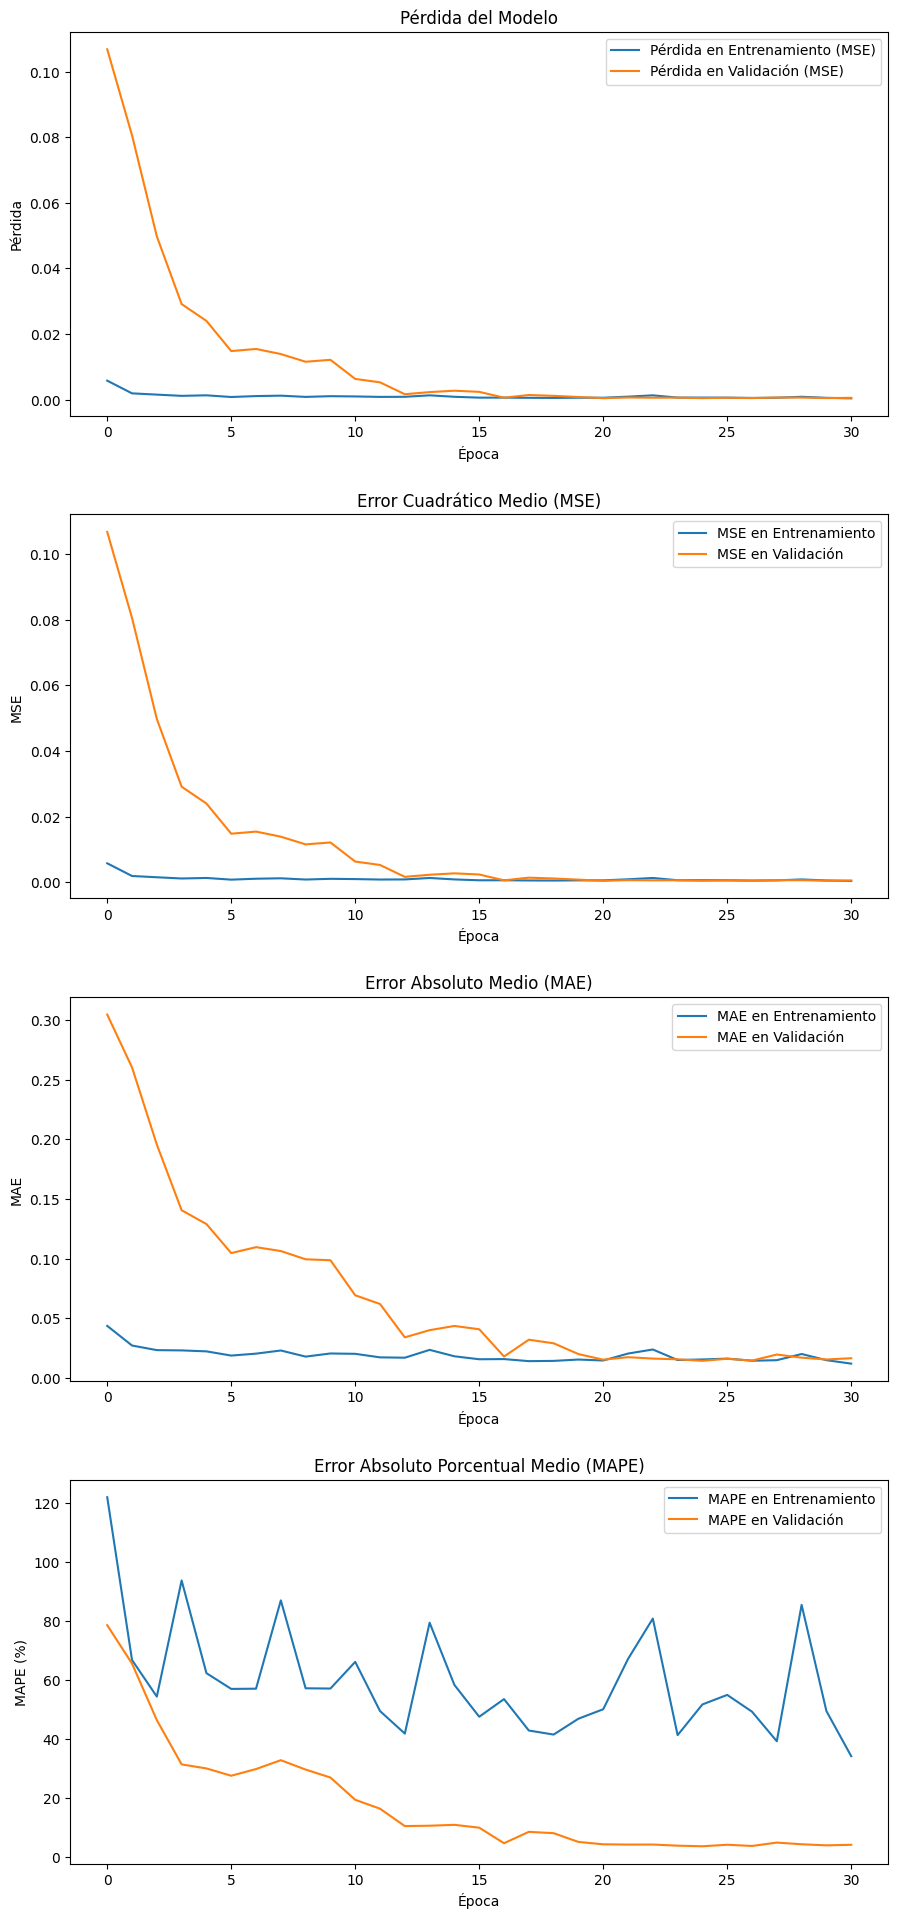

In [19]:
import matplotlib.pyplot as plt

# Crear una figura con 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

# Gráfico de la pérdida
axes[0].plot(hist.history['loss'], label="Pérdida en Entrenamiento (MSE)")
axes[0].plot(hist.history['val_loss'], label="Pérdida en Validación (MSE)")
axes[0].set_title("Pérdida del Modelo")
axes[0].set_ylabel("Pérdida")
axes[0].set_xlabel("Época")
axes[0].legend()

# Gráfico del MSE
axes[1].plot(hist.history['mean_squared_error'], label="MSE en Entrenamiento")
axes[1].plot(hist.history['val_mean_squared_error'], label="MSE en Validación")
axes[1].set_title("Error Cuadrático Medio (MSE)")
axes[1].set_ylabel("MSE")
axes[1].set_xlabel("Época")
axes[1].legend()

# Gráfico del MAE
axes[2].plot(hist.history['mean_absolute_error'], label="MAE en Entrenamiento")
axes[2].plot(hist.history['val_mean_absolute_error'], label="MAE en Validación")
axes[2].set_title("Error Absoluto Medio (MAE)")
axes[2].set_ylabel("MAE")
axes[2].set_xlabel("Época")
axes[2].legend()

# Gráfico del MAPE
axes[3].plot(hist.history['mean_absolute_percentage_error'], label="MAPE en Entrenamiento")
axes[3].plot(hist.history['val_mean_absolute_percentage_error'], label="MAPE en Validación")
axes[3].set_title("Error Absoluto Porcentual Medio (MAPE)")
axes[3].set_ylabel("MAPE (%)")
axes[3].set_xlabel("Época")
axes[3].legend()

plt.show()



### Prediccion

In [38]:
x_test = sc.fit_transform(test_set)

In [39]:
X_test = []
for i in range(block_size,len(x_test)):
    X_test.append(x_test[i-block_size:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [40]:
prediccion = model.predict(X_test)

In [41]:
prediccion = sc.inverse_transform(prediccion)
graph = test_set[block_size:]
graph['Prediction']  = prediccion

C:\Users\GMS\AppData\Local\Temp\ipykernel_11852\3464148111.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph['Prediction']  = prediccion


In [42]:
def change(pred):
    change = []
    for x in range(0,len(pred)):
        if x < len(pred)-1:
            if pred[x] < pred[x+1]:
                change.append(1)
            else:
                change.append(0)
        else:
            change.append(1)
    return change
graph['Change'] = change(prediccion)

C:\Users\GMS\AppData\Local\Temp\ipykernel_11852\1289621115.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph['Change'] = change(prediccion)


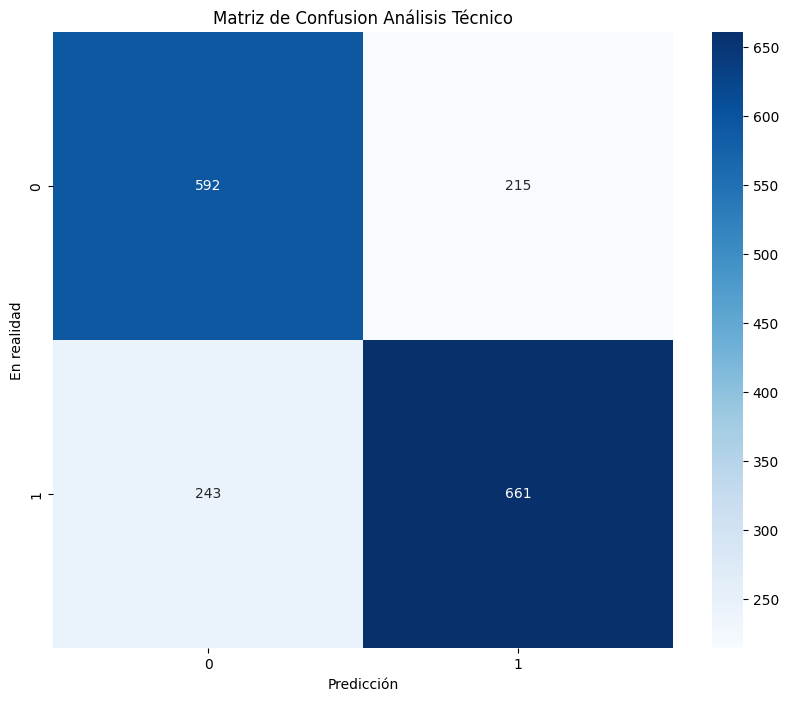

In [43]:

conf_matrix = confusion_matrix(graph["Change"], bp["Category"][graph.index.min():])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicción')
plt.ylabel('En realidad')
plt.title('Matriz de Confusion Análisis Técnico')
plt.show()

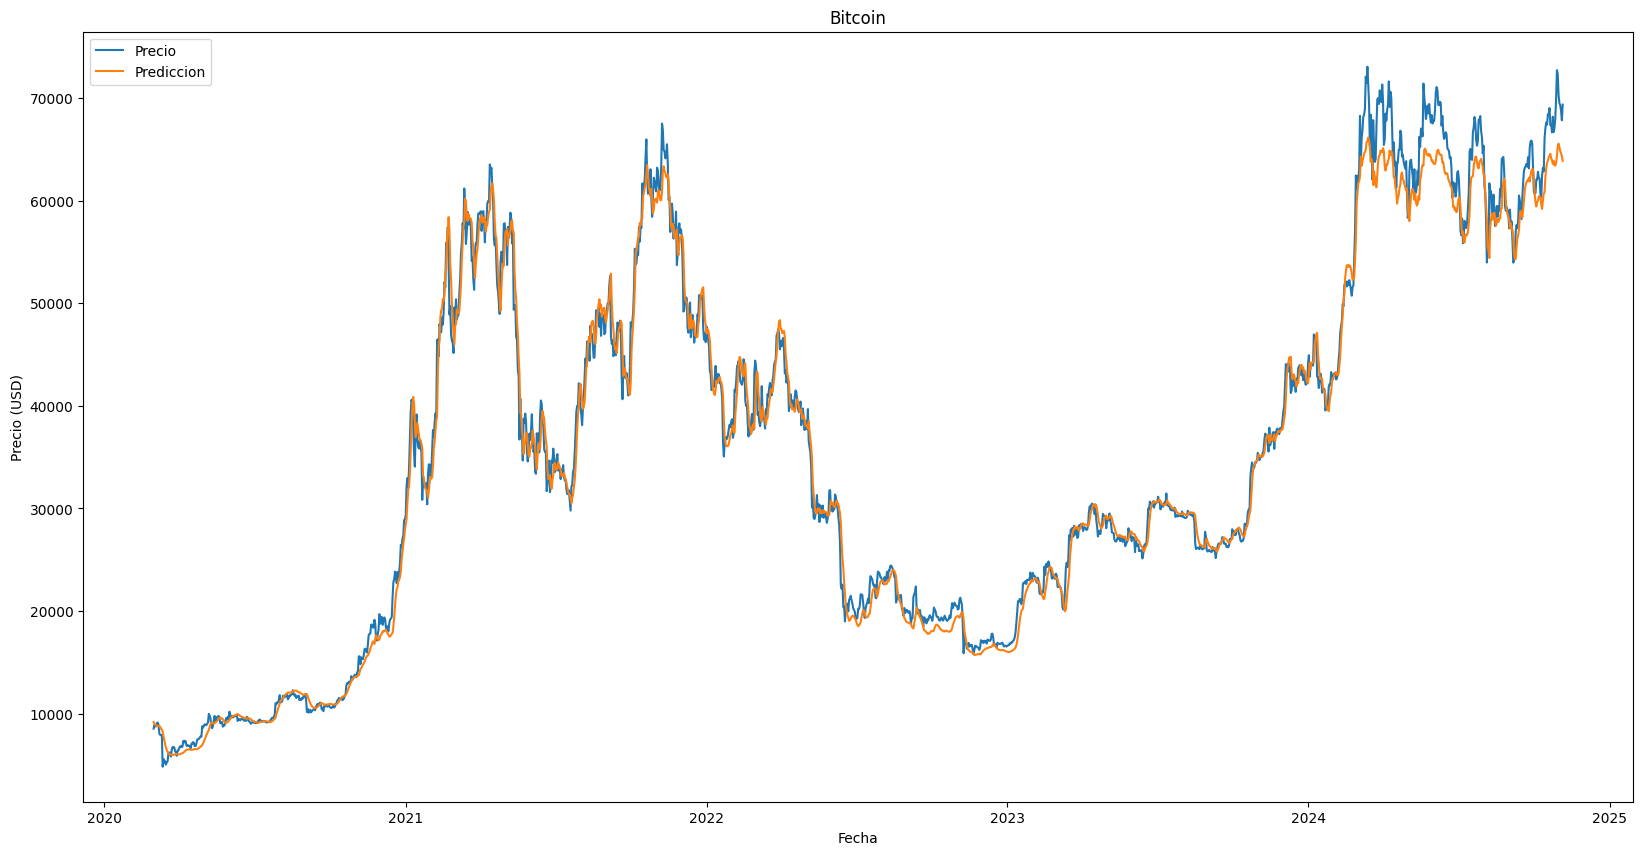

In [44]:
plt.figure(figsize=(20, 10))
sns.lineplot(x='Date', y='Price', data=graph, label='Precio')
sns.lineplot(x='Date', y='Prediction', data=graph, label='Prediccion')
plt.title('Bitcoin')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()

In [58]:
import numpy as np

# Supongamos que estas son las predicciones de tu modelo
predicciones = np.array(prediccion.flatten())

# Calcular diferencias entre valores consecutivos
diferencias = np.diff(predicciones)

# Clasificar como subida (1) o bajada (0)
clasificaciones = np.where(diferencias > 0, 1, 0)

# Calcular la probabilidad de subida y bajada
total = len(clasificaciones)
probabilidad_subida = np.sum(clasificaciones) / total
probabilidad_bajada = 1 - probabilidad_subida

# Mostrar resultados
print(f"Probabilidad de subida: {probabilidad_subida * 100:.2f}%")
print(f"Probabilidad de bajada: {probabilidad_bajada * 100:.2f}%")


Probabilidad de subida: 52.81%
Probabilidad de bajada: 47.19%


In [46]:
# Guarda el modelo sin especificar `batch_shape`
# model.save('model.h5', save_format='h5')



